# Wind Turbine Suitability Prediction Model

## Exploratory Data Analysis and Pre-Processing

The primary objective for dataset pre-processing will be to clean it. Because we are using real measurements from real weather stations, many of the submitted datapoints will have null values, and some stations don't even report the measurments that we are looking for.

After performing the pre-processing we will then perform exploratory data analysis to look for potential patterns and trends in the visualized distributions and correlation heatmaps that could point us towards what machine learning models might perform best.


### Load the Dataset

Because of the sheer size of our dataset, it had to be extracted and saved into different batches to help with performance. Thus, the first step is to compile all of these batch folders into a single dataframe.

In [1]:
import pandas as pd
from pathlib import Path

labeled_data_dir = Path('data/labeled_mesonet_data')
batch_folders = sorted(labeled_data_dir.glob('batch_*'))

all_dfs = []
for batch_folder in batch_folders:
    for csv_file in batch_folder.glob('*_measurements.csv'):
        df = pd.read_csv(csv_file)
        all_dfs.append(df)

df_combined = pd.concat(all_dfs, ignore_index=True)

print(f"Loaded {len(all_dfs)} CSV files from {len(batch_folders)} batches")
print(f"\nDataframe shape (rows, columns): {df_combined.shape}")
print(f"\nAll columns: {df_combined.columns.tolist()}")

Loaded 2741 CSV files from 28 batches

Dataframe shape (rows, columns): (1025763, 30)

All columns: ['time', 'airTemperature', 'avgGlobalSolarRadiation', 'barometricPressure', 'cumulativeGlobalSolarRadiation', 'dewPointTemperature', 'fireWeatherIndex', 'heatIndex', 'mslp', 'precipitation', 'precipitationRate', 'rainfall', 'reflectedShortwaveRadiation', 'relativeHumidity', 'seaSurfaceTemperature', 'seaSurfaceTemperature1m', 'snowDepth', 'snowfall', 'visibility', 'waveDirection', 'waveHeight', 'waveHeightMax', 'wetBulbTemperature', 'windChill', 'windDirection', 'windGust', 'windGust10m', 'windSpeed', 'windSpeed10m', 'TurbineScore']


### Initial Null Data Analysis

After loading the dataset, we start by removing any completely null rows (excluding time and turbine score), and then look for the null value counts for each column (feature) in order to select the features with the most data.

In [2]:
# Remove rows that are largely null (except for 'time' and 'TurbineScore' columns)

df_combined.dropna(how='all', subset=df_combined.columns.difference(['time', 'TurbineScore']), inplace=True)
print(f"\nDataframe shape after dropping largely null rows: {df_combined.shape}")


Dataframe shape after dropping largely null rows: (858618, 30)


In [3]:
# Get statistics and null value counts

display(df_combined.describe()) # Display basic statistics

# Column null counts
null_counts = df_combined.isnull().sum().sort_values(ascending=False)
print(f'\nNull value counts per column: \n{null_counts}')

# Number of rows with no null columns
num_complete_rows = df_combined.dropna().shape[0]
print(f'\nNumber of complete rows (no nulls): {num_complete_rows}')

,airTemperature,avgGlobalSolarRadiation,barometricPressure,cumulativeGlobalSolarRadiation,dewPointTemperature,fireWeatherIndex,heatIndex,mslp,precipitation,precipitationRate,...,waveHeight,waveHeightMax,wetBulbTemperature,windChill,windDirection,windGust,windGust10m,windSpeed,windSpeed10m,TurbineScore
count,811000.000000,6.303300e+04,4.026130e+05,16322.000000,729534.000000,54743.000000,223.000000,398271.000000,4.223820e+05,26231.000000,...,12862.000000,8558.000000,182242.000000,225.000000,674327.000000,9.986500e+04,5.323690e+05,1.448070e+05,7.005970e+05,858618.000000
mean,4.749284,-1.915557e+27,-7.737897e+25,741.479261,-0.466643,8.496059,9.080835,1015.388914,-3.961043e+25,0.101072,...,0.666042,1.786956,5.602005,5.247004,193.907188,-6.114396e+26,-1.362232e+26,-1.262156e+26,-3.098355e+25,0.532814
std,12.254847,1.736563e+29,4.909835e+28,457.151084,11.665375,8.856817,9.856910,11.619719,2.190073e+28,0.362739,...,0.594322,1.719636,10.238480,11.863144,66.270606,1.805581e+29,9.287835e+28,4.802943e+28,2.593373e+28,0.498922
min,-55.283130,-1.678201e+31,-3.115378e+31,0.000000,-97.741667,0.000000,-18.925000,778.837500,-1.396151e+31,0.000000,...,0.000000,0.000000,-55.349179,-30.383333,-67.333333,-5.690757e+31,-6.758760e+31,-1.827688e+31,-2.170697e+31,0.000000
25%,-2.472728,1.088542e+02,9.560958e+02,379.156598,-6.703044,0.807458,4.991667,1009.797222,0.000000e+00,0.000000,...,0.200000,0.500000,0.545087,1.527273,148.291667,8.941500e+00,1.197119e+01,3.717391e+00,4.769444e+00,0.000000
50%,6.675000,1.821071e+02,9.865375e+02,704.586373,1.373556,5.925696,11.550000,1015.587500,1.842105e-02,0.000000,...,0.541667,1.237500,7.762149,8.057895,195.333333,1.363636e+01,1.797083e+01,6.616667e+00,8.206122e+00,1.000000
75%,14.475060,2.603208e+02,1.005250e+03,1053.185032,8.218109,13.500000,15.597143,1021.241667,2.883651e-01,0.027917,...,1.000000,2.516667,12.996013,12.540000,242.791667,2.056667e+01,2.770000e+01,1.171250e+01,1.338333e+01,1.000000
max,391.183333,8.287321e+23,7.145204e+03,3151.720000,45.444737,86.500000,26.233333,1130.350000,8.287321e+23,15.988889,...,6.833333,16.966667,31.725000,24.166667,423.384615,1.317000e+02,9.882125e+02,5.764608e+12,6.846470e+12,1.000000



Null value counts per column: 
heatIndex                         858395
windChill                         858393
reflectedShortwaveRadiation       858354
seaSurfaceTemperature1m           857986
waveDirection                     851959
seaSurfaceTemperature             850836
waveHeightMax                     850060
waveHeight                        845756
snowfall                          842990
cumulativeGlobalSolarRadiation    842296
precipitationRate                 832387
fireWeatherIndex                  803875
avgGlobalSolarRadiation           795585
windGust                          758753
snowDepth                         755144
visibility                        755045
windSpeed                         713811
wetBulbTemperature                676376
rainfall                          575027
mslp                              460347
barometricPressure                456005
precipitation                     436236
windGust10m                       326249
windDirection            

### Null Data Removal

From the above step, we selected the features with the least null value counts for further analysis and then compared dataset size for different null count thresholds to determine how much null values are acceptable to get a reasonably sized dataset.

In [4]:
selected_columns = [
    'mslp',
    'barometricPressure',
    'windDirection',
    'windSpeed10m',
    'relativeHumidity',
    'dewPointTemperature',
    'airTemperature',
    'TurbineScore'
]
df_selected = df_combined[selected_columns].copy()

# Number of rows with no/<2/<3 null values in selected columns
num_complete_selected_rows = df_selected.dropna().shape[0]
print(f'\nNumber of complete rows in selected columns: {num_complete_selected_rows}')

num_rows_at_most_1_null = df_selected[df_selected.isnull().sum(axis=1) <= 1].shape[0]
print(f'Number of rows with at most 1 null value in selected columns: {num_rows_at_most_1_null}')

num_rows_at_most_2_null = df_selected[df_selected.isnull().sum(axis=1) <= 2].shape[0]
print(f'Number of rows with at most 2 null values in selected columns: {num_rows_at_most_2_null}')


Number of complete rows in selected columns: 368320
Number of rows with at most 1 null value in selected columns: 379036
Number of rows with at most 2 null values in selected columns: 671919


### Data Imputation
For data with only 1 null value, we consider it to be sufficiently clean to be used for analysis, and perform data imputation with the median value on the null value. The reason we use the median and not the mean is because our dataset has a wide range of values for the different features, and outliers from remote weather stations could negatively affect the mean.

In [5]:
# Remove rows with more than 1 null value in selected columns
df_final = df_selected[df_selected.isnull().sum(axis=1) <= 1].copy()
print(f'\nFinal dataframe shape after filtering: {df_final.shape}')

# Perform data imputation on null values (median)
for column in selected_columns:
    if column != 'TurbineScore':
        median_value = df_final[column].median()
        df_final[column] = df_final[column].fillna(median_value)

df_final.head()


Final dataframe shape after filtering: (379036, 8)


,mslp,barometricPressure,windDirection,windSpeed10m,relativeHumidity,dewPointTemperature,airTemperature,TurbineScore
13,1014.000000,980.531429,186.171429,6.971429,67.571429,1.462857,7.217143,0
14,1008.726316,974.055882,268.352941,7.568627,90.044118,3.001471,4.545588,0
15,1003.692857,970.162162,224.121622,3.979730,96.838235,5.119118,5.504054,0
16,1009.777778,975.898810,176.952381,11.085979,99.869048,3.626190,3.644048,0
17,1018.037500,984.005000,186.533333,6.037963,99.833333,2.620000,2.645000,0


### Exploratory Data Analysis

For our exploratory data analysis, we visualized the relationships between each feature and then computed a correlation heatmap, with the intent to find visual patterns that could suggest the use of different machine learning techniques.

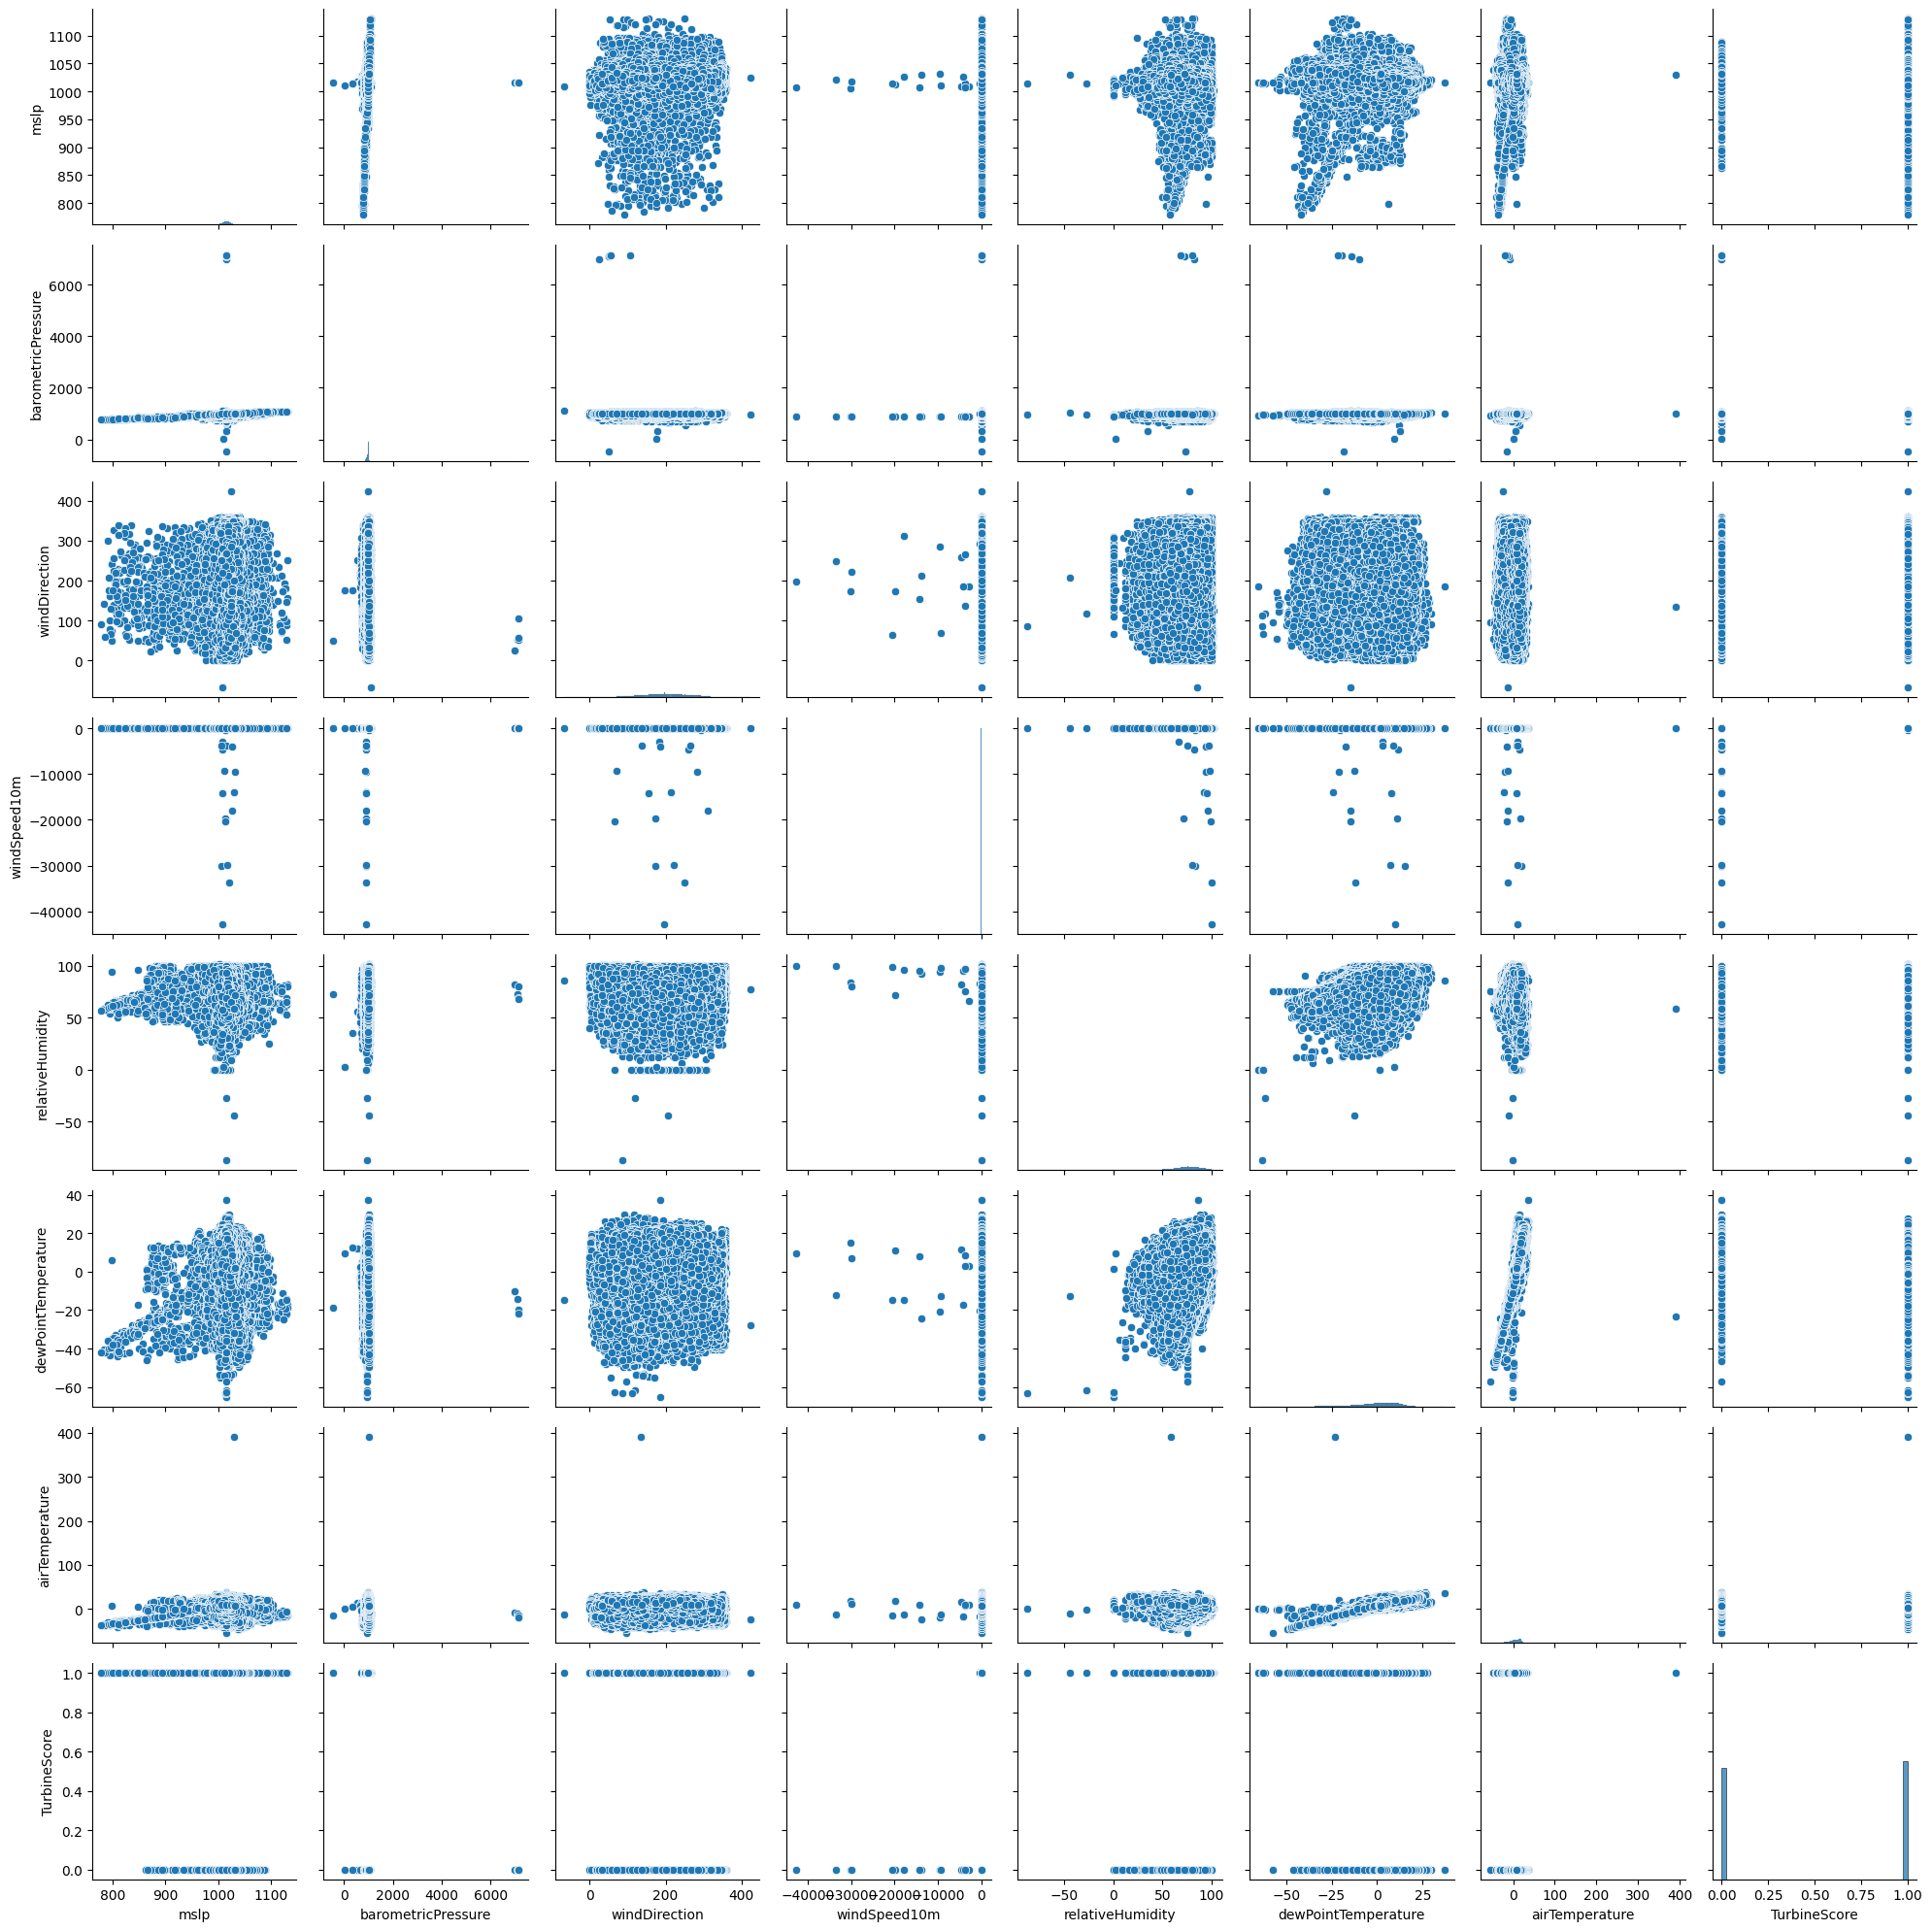

In [6]:
# Visualize relationships between features

import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_final, height=2.5)
plt.tight_layout()
plt.show()

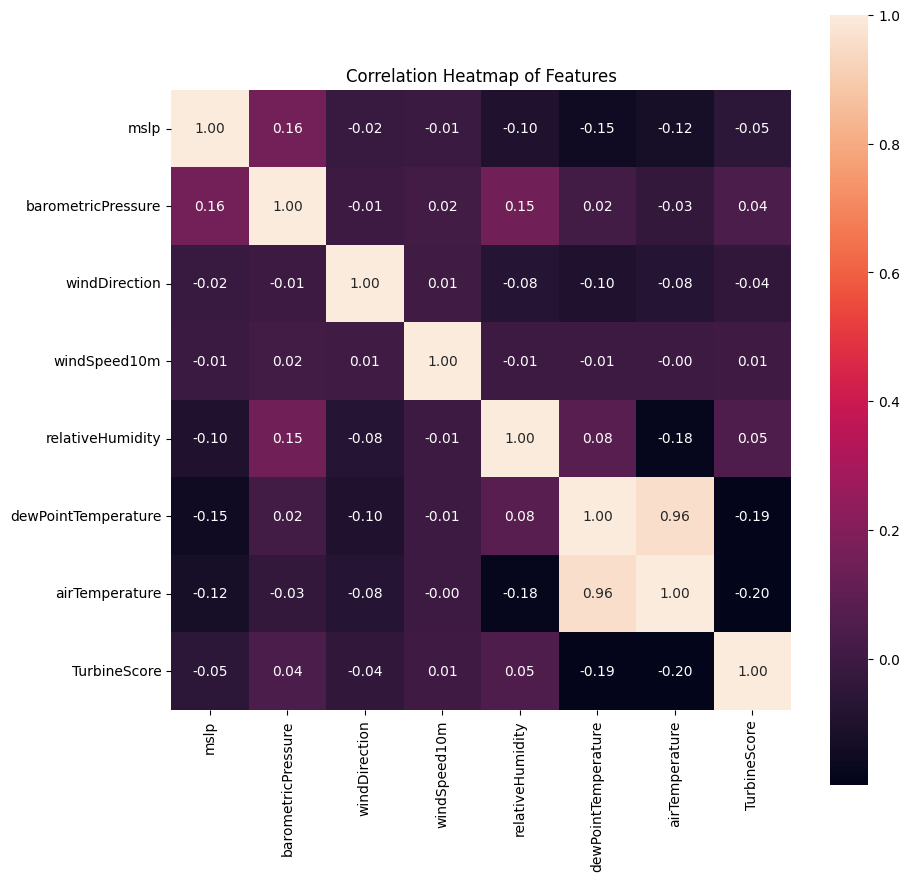

In [7]:
# Visualize correlation heatmap

correlation_matrix = df_final.corr()
plt.figure(figsize=(10, 10))
hm = sns.heatmap(correlation_matrix, cbar=True,annot=True,
                 square=True, fmt='.2f',
                 yticklabels=correlation_matrix.columns,
                 xticklabels=correlation_matrix.columns)

plt.title("Correlation Heatmap of Features")
plt.show()

Unfortunately, these visualized distributions do not show any clear linear correlations between features and the target label. This is to be expected given the high dimensionality of the problem (i.e., many different weather factors are indicative of good weather, not just a single one). This suggests that models such as Logistic Regression or linear SVMs will underperform compared to models that can create more non-linear representations of the data.

## Model Exploration

The next step is to select which model to perform further analysis on. Given our previous findings during exploratory data analysis, it is likely that non-linear methods will perform best, but we will still test some of them in order to verify this. We will perform model training on the following models:
1. Support Vector Machine (SVM) 
2. Logistic Regression
3. K-Nearest Neighbours
4. Random Forest
5. XGradient Boost
6. Multi-Layer-Perceptron


### Model Training and Testing Pipeline

As done in the assignments, we will pre-define the training and testing sets as well as the functions for training and evaluating the models, so that they can all be run through a similar pipeline for easy analysis.

Note that because we are using a multi-layer perceptron, we will also include optional support in the train model function to support the collection of validation loss over epochs.

In [8]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

X = df_final[selected_columns[:-1]]
y = (df_final['TurbineScore'] > 0.5).astype(int)

# (For neural network, X_train and y_train will be split into training and validation sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

def train_model(model, X_train, y_train, X_val=None, y_val=None):
    ''' Helper function to train the model and return the time taken '''

    start_time = time.time()
    
    train_losses = []
    val_losses = []
    
    # Get the classifier from the pipeline (last step)
    if hasattr(model, 'named_steps'):
        classifier = list(model.named_steps.values())[-1]
    else:
        classifier = model
    
    # Checking if the classifier supports iterative training (warm_start=True)
    if hasattr(classifier, 'warm_start') and classifier.warm_start:
        for i in range(10):
            model.fit(X_train, y_train)
            
            # Training loss
            if hasattr(classifier, 'loss_'):
                train_losses.append(classifier.loss_)
            
            # Validation loss
            if X_val is not None and y_val is not None and hasattr(model, 'predict_proba'):
                y_val_pred_proba = model.predict_proba(X_val)
                val_loss = log_loss(y_val, y_val_pred_proba)
                val_losses.append(val_loss)

    else:
        model.fit(X_train, y_train)
        
    train_time = (time.time() - start_time) * 1000 # (Converting to ms)
    return train_time, train_losses, val_losses


def test_model(model, model_name):
    ''' Helper function to test the model and return time taken '''

    start_time = time.time()
    y_test_pred = model.predict(X_test)
    test_time = (time.time() - start_time) * 1000
    
    # Reporting metrics of predictions (for Q2.1)
    print(f"\n--- {model_name} PREDICTION RESULTS ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("F1 Score: ", f1_score(y_test, y_test_pred))
    print("Recall: ", recall_score(y_test, y_test_pred))
    print("Precision: ", precision_score(y_test, y_test_pred))
    print("Accuracy: ", accuracy_score(y_test, y_test_pred))

    # Plotting ROC curve and reporting AUC of predictions (for Q2.2)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()
        
    return test_time


### Model 1 - SVM

For the SVM model we will use the SVC variant (which is used for classification problems) with a kernel set to 'RBF'. The introduction of a kernel in RBF mode will create a non-linear decision boundary which should help to identify non-linear relationships, which we expect our dataset to have considering the findings from exploratory data analysis.

SVM TRAINING TIME: 2568281.86 ms

--- SVM PREDICTION RESULTS ---
Confusion Matrix:
 [[18353  3417]
 [ 9158  6976]]
F1 Score:  0.5259546876767067
Recall:  0.4323788273211851
Precision:  0.6712210141441355
Accuracy:  0.6682408189109329


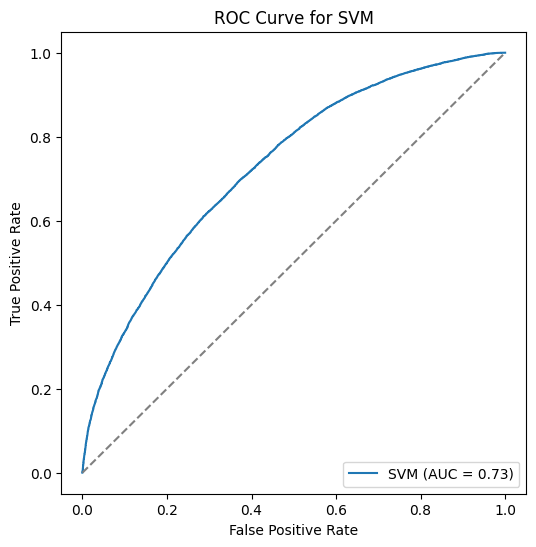

SVM TESTING TIME: 420176.01 ms


In [ ]:
# svm_model = Pipeline([
#     ('scale', StandardScaler()),
#     ('svm', SVC(kernel='rbf', gamma='scale')) 
#     ])

# svm_train_time, _, _ = train_model(svm_model, X_train, y_train)
# print(f"SVM TRAINING TIME: {svm_train_time:.2f} ms")

# svm_test_time = test_model(svm_model, "SVM")
# print(f"SVM TESTING TIME: {svm_test_time:.2f} ms")

### Model 2 - KNN

For the KNN model, we were unsure what parameters would perform best for our model. In order to experiment with different combinations of parameters, we performed a grid search with the following parameter grid. We then selected the best performing combination for the final model.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
KNN TRAINING TIME: 416.03 ms

--- KNN PREDICTION RESULTS ---
Confusion Matrix:
 [[16888  4882]
 [ 6066 10068]]
F1 Score:  0.6477930768240896
Recall:  0.6240238006693938
Precision:  0.6734448160535117
Accuracy:  0.7111650485436893


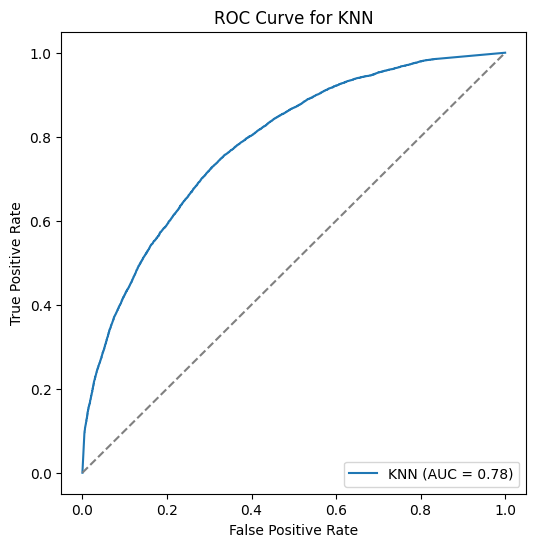

KNN TESTING TIME: 7776.01 ms


In [ ]:
# knn_param_grid = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# knn = KNeighborsClassifier()
# knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, n_jobs=-1, verbose=1)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# knn_grid_search.fit(X_train_scaled, y_train)

# knn_model = knn_grid_search.best_estimator_
# knn_train_time, _, _ = train_model(knn_model, X_train, y_train)
# print(f"KNN TRAINING TIME: {knn_train_time:.2f} ms")

# knn_test_time = test_model(knn_model, "KNN")
# print(f"KNN TESTING TIME: {knn_test_time:.2f} ms")

### Model 3 - Logistic Regression

We did not expect logistic regression to perform well, as without the introduction of polynomial features it is unable to capture anything but a linear decision boundary. However, in order to verify this we still had to include it in our testing.

LOGISTIC REGRESSION TRAINING TIME: 304.01 ms

--- Logistic Regression PREDICTION RESULTS ---
Confusion Matrix:
 [[17632  4138]
 [10798  5336]]
F1 Score:  0.4167447672602312
Recall:  0.33073013511838356
Precision:  0.5632256702554359
Accuracy:  0.6059518784297172


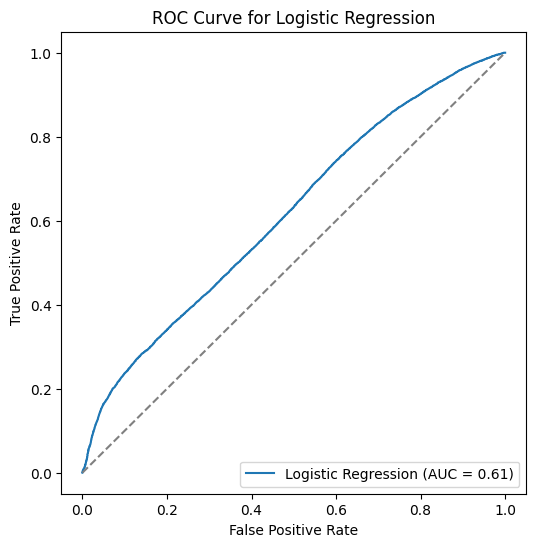

LOGISTIC REGRESSION TESTING TIME: 2.50 ms


In [ ]:
# log_reg_model = Pipeline([
#     ('scale', StandardScaler()),
#     ('log_reg', LogisticRegression(max_iter=10000, random_state=42))
#     ])

# log_reg_train_time, _, _ = train_model(log_reg_model, X_train, y_train)
# print(f"LOGISTIC REGRESSION TRAINING TIME: {log_reg_train_time:.2f} ms")

# log_reg_test_time = test_model(log_reg_model, "Logistic Regression")
# print(f"LOGISTIC REGRESSION TESTING TIME: {log_reg_test_time:.2f} ms")

### Model 4 - Random Forest

Tree-based models are generally well-suited for classification problems, including those with non-linear relationships. As such, we wanted to experiment with many possible paramters to fit the best model. We identified 324 total fits and used grid search to find the best fit for our model.

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/collin/school/ds3000a-project-group10/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RANDOM FOREST TRAINING TIME: 167561.24 ms

--- Random Forest PREDICTION RESULTS ---
Confusion Matrix:
 [[13641  4781]
 [ 4325 15157]]
F1 Score:  0.7690005073566717
Recall:  0.7780002053177292
Precision:  0.760206640585816
Accuracy:  0.7597615027437737


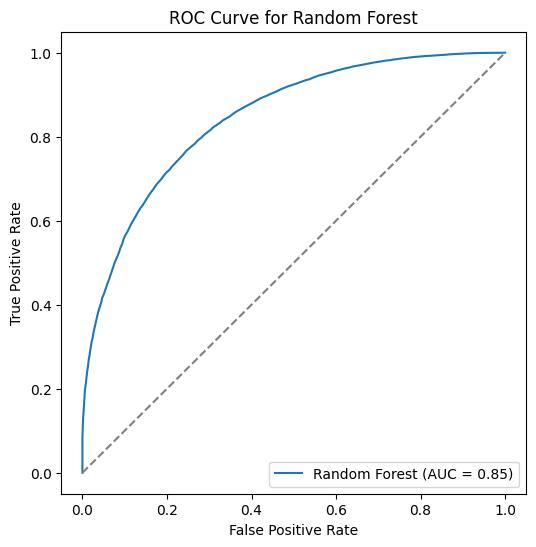

RANDOM FOREST TESTING TIME: 1358.77 ms


In [9]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 25, 50],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_forest = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_params,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)
random_forest_model = rf_grid_search.best_estimator_

random_forest_model_train_time, _, _ = train_model(random_forest_model, X_train, y_train)
print(f"RANDOM FOREST TRAINING TIME: {random_forest_model_train_time:.2f} ms")

random_forest_test_time = test_model(random_forest_model, "Random Forest")
print(f"RANDOM FOREST TESTING TIME: {random_forest_test_time:.2f} ms")

### Model 5 - XGBoost

Gradient boosting is also a very popular machine learning technique for data with non-linear relationships. As such, we also performed a grid search with 108 different combinations of parameters totalling 324 fits.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
XGBOOST TRAINING TIME: 9250.87 ms

--- XGBoost PREDICTION RESULTS ---
Confusion Matrix:
 [[13515  4907]
 [ 4384 15098]]
F1 Score:  0.7647073720464963
Recall:  0.774971768812237
Precision:  0.7547113221694577
Accuracy:  0.7548807513718869


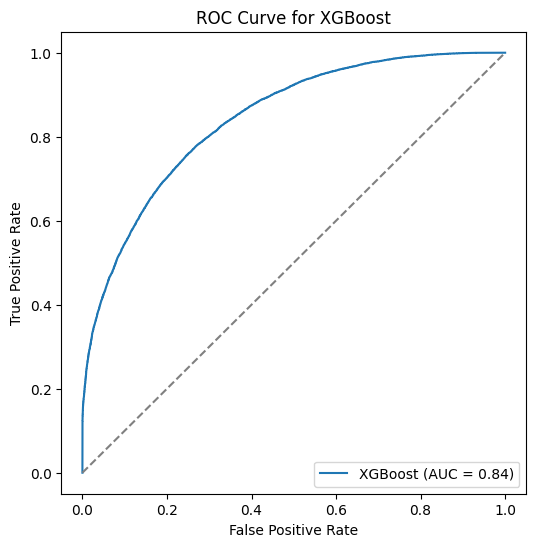

XGBOOST TESTING TIME: 61.69 ms


In [10]:
from xgboost import XGBClassifier

grid_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb = XGBClassifier(random_state=42)
xgb_grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=grid_params,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_model = xgb_grid_search.fit(X_train, y_train).best_estimator_

xgb_model_train_time, _, _ = train_model(xgb_model, X_train, y_train)
print(f"XGBOOST TRAINING TIME: {xgb_model_train_time:.2f} ms") 

xgb_test_time = test_model(xgb_model, "XGBoost")
print(f"XGBOOST TESTING TIME: {xgb_test_time:.2f} ms")

### Model 6 - MLP

Finally, a multi-layer perceptron was used to finish the exploration process. This model required the training data to be split into training and validation sets, which allowed us to visualize the trend of validation accuracy (and thus detect overfitting if it occurs).

c:\Users\david\GitHub\ds3000a-project-group10\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP TRAINING TIME: 228709.09 ms


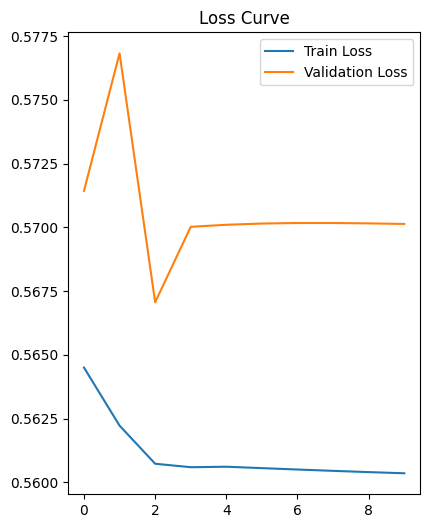


--- MLP PREDICTION RESULTS ---
Confusion Matrix:
 [[16847  4923]
 [ 6559  9575]]
F1 Score:  0.6251632279968661
Recall:  0.5934672120986736
Precision:  0.660435922196165
Accuracy:  0.6970768256648375


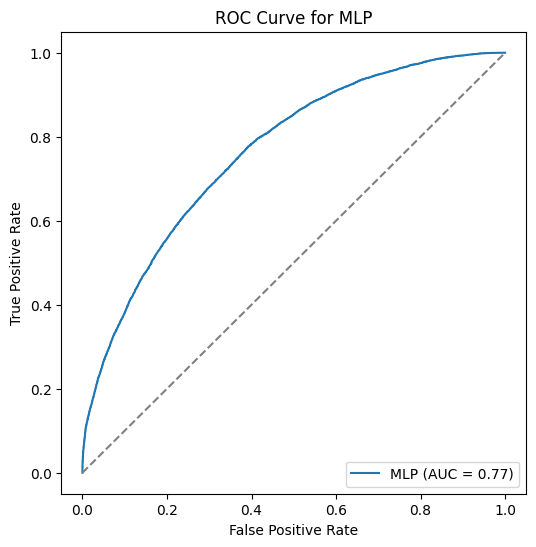

MLP TESTING TIME: 87.00 ms


In [ ]:
# from sklearn.neural_network import MLPClassifier
# import matplotlib.pyplot as plt

# X_train_nn, X_val, y_train_nn, y_val = train_test_split(
#     X_train, y_train, test_size=0.222, random_state=42 # 0.222 * 0.9 = 0.2
# )

# mlp_model = Pipeline([
#     ('scale', StandardScaler()),
#     ('mlp', MLPClassifier(hidden_layer_sizes=(50, 100),
#                                  activation='tanh',
#                                  solver='sgd',
#                                  learning_rate_init=0.1,
#                                  max_iter=100,
#                                  warm_start=True,
#                                  random_state=42)
#     )
# ])

# mlp_train_time, mlp_train_losses, mlp_validation_losses = train_model(mlp_model, X_train_nn, y_train_nn, X_val, y_val)
# print(f"MLP TRAINING TIME: {mlp_train_time:.2f} ms")

# plt.figure(figsize=(10,6))
# plt.subplot(1,2,1)
# plt.plot(mlp_train_losses, label='Train Loss')
# plt.plot(mlp_validation_losses, label='Validation Loss')
# plt.legend()
# plt.title("Loss Curve")

# plt.show()

# mlp_test_time = test_model(mlp_model, "MLP")
# print(f"MLP TESTING TIME: {mlp_test_time:.2f} ms")

## Model Selection & Testing

Given the 6 models' performances, the clear winners are the **Random Forest model** and the **XGBoost model**, with a nearly **10%** increase in accuracy over the other candidates. This aligns with our initial assumptions that the patterns in our dataset are not linear in nature.

With these selected models, the final step will be to perform any potential optimizations to reduce overfitting, namely **regularization**.

For the Random Forest model, regularization is implicitly performed through the customization of the max_depth value, which naturally restricts the number of features that it can extract from the data. For XGBoost however, we can directly tune for L2 or L1 regularization using the **lambda** and **alpha** parameters respectively.

### Feature Importance

We can start by observing the feature importance derived from the selected models.

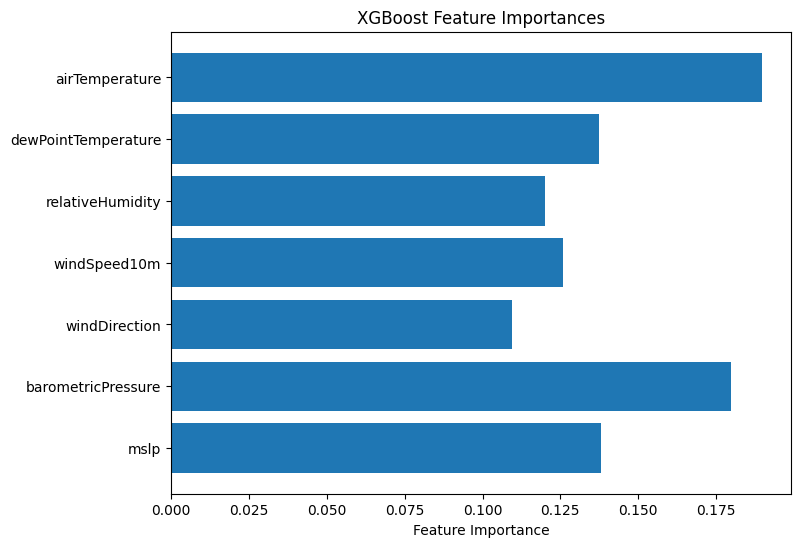

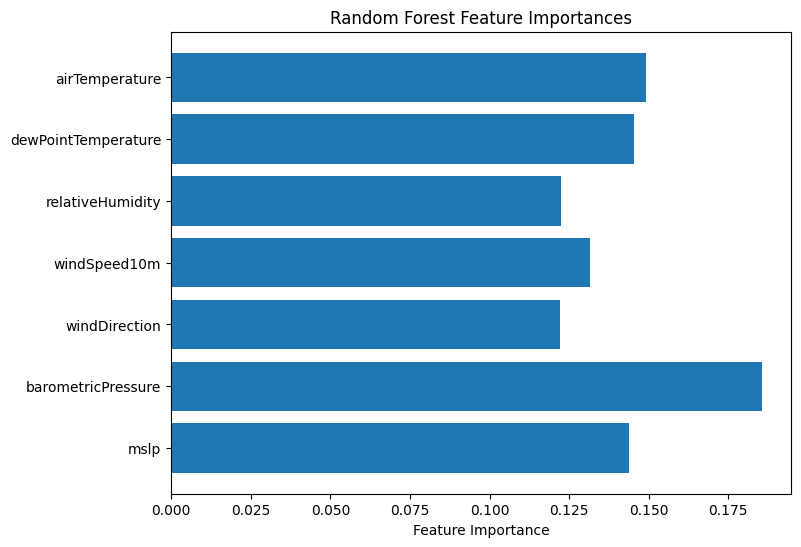

In [ ]:
def plot_feature_importances(model, model_name):
    importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(selected_columns[:-1], importances)
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name} Feature Importances')
    plt.show()

# Plot the feature importances for the models
plot_feature_importances(xgb_model, "XGBoost")
plot_feature_importances(random_forest_model, "Random Forest")

Based on the feature importance plots above, we can see that both models assign very similar importance to most features with no real outliers. This suggests that both models are extracting similar patterns from the data, which is expected given their similar accuracies.

Due to this, we can also conclude that regularization is not strictly necessary for either model, as there are no features that are being overemphasized to the detriment of others.